# Music synthesis tutorial

## 1. Additive synthesis

This method synthesizes sounds by constructing a complex tone made of a fundamental and several harmonics. The tone is obtained by adding together all these components.

In [30]:
# Import modules

import math
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.signal import freqz
from scipy.signal import sosfreqz

<br>
The function below can be used to synthesize a complex tone containing a fundamental frequency and a number of its harmonics, all scaled by different amplitudes and added to one another at different phase shifts. The number of components is set to 5 currently, but can be easily changed by passing a value for the argument 'n_comp' when calling the function.
<br>

In [31]:
# Function to generate complex tone

def generate_complex_tone(f0, fs, amplitudes, phases, duration, n_comp=5):
    '''
    Arguments:
    f0 - fundamental freq
    fs - sampling freq
    amplitudes, phases - absolute amplitude and phase value for the f0 and the harmonics
    
    Returns the complex tone signal
    '''
    assert len(amplitudes) == n_comp, "Incorrect number of amplitudes provided"
    assert len(phases) == n_comp, "Incorrect number of phases provided"
    
    n=np.arange(0,duration*fs)
    x=np.zeros(len(n))
    
    for i in range(len(amplitudes)):
        x = x + amplitudes[i]*np.sin(2*np.pi*(i+1)*(f0/fs)*n + phases[i])
    return x

<br>
Set the parameters for synthesis - the F0, duration, amplitudes and phases of all the components.

In [33]:
# Parameters for synthesis

pi = np.pi
f0=1000                   #in Hz
fs=16000                 #in samples/s
amplitudes=[3,1,2,1,0]
phases=[pi/2,pi/2,pi/2,pi/2,pi/2]
duration=3              #in seconds

<br>
Call the function to generate the tone and plot its waveform and magnitude spectrum. Play around with the values of the amplitudes & phases and see if you notice any changes in the resulting audio and plots. Also observe the effect of changing the fs, f0 and n_fft on the magnitude spectrum.

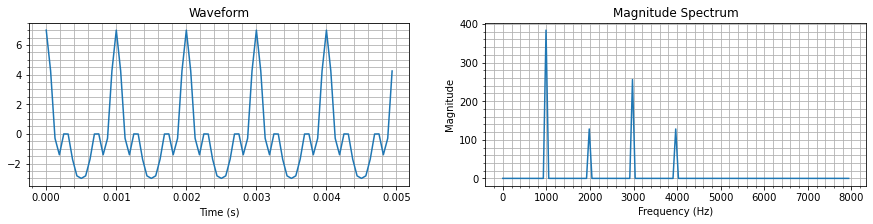

In [34]:
# Change below line to '%matplotlib notebook'  to allow zooming in, moving the plot around, etc.
%matplotlib inline 

# Generate a tone based on above specifications
x = generate_complex_tone(f0,fs,amplitudes,phases,duration,n_comp=5)

# Calculate the DFT of x
n_fft=256
x_spec = np.fft.rfft(x,n_fft)

t = np.arange(len(x))/fs
f = np.arange(len(x_spec))*fs/(2*len(x_spec))

# Plot the waveform
fig,ax=plt.subplots(1,2,figsize=(15, 3))
ax[0].plot(t[:5*fs//f0], x[:5*fs//f0])
ax[0].set_title('Waveform'); ax[0].set_xlabel('Time (s)')
ax[0].minorticks_on(); ax[0].grid(which='both')

# Plot the magnitude spectrum
ax[1].plot(f, np.abs(x_spec))
ax[1].set_title('Magnitude Spectrum')
ax[1].set_xlabel('Frequency (Hz)'); ax[1].set_ylabel('Magnitude')
ax[1].minorticks_on(); ax[1].grid(which='both')

plt.show()
ipd.display(ipd.Audio(data=x, rate=fs))

## 2. Subtractive synthesis

This method makes use of the source-filter model for sound synthesis, where a source excitation, like an impulse train, is filtered by an LTI system such as an all-pole resonator. The following example is therefore worked in parts - first generating the source excitation, then designing the filter, and finally filtering the source signal using this filter. In this example, we make use of an all-pole resonator and implement the filtering using the difference equation method.

We first define functions for each of these operations below and then call them.


Function to generate the source excitation

In [35]:
def generate_source(F0, Fs, duration, plot=True):
    '''
    Arguments: 
    F0 - fundamental frequency
    Fs - sampling rate

    Returns a source (triangular)impulse train and plots the waveform
    '''
    Ts=1.0/Fs
    source = np.zeros(int(duration/Ts)) # initialize source signal array with length = dur sec = dur*Fs samples
    interval = int((1.0/F0)/Ts) # spacing between two consecutive impulses (in samples)
    locs = np.arange(0, len(source), interval) # locations of impulse
    source[locs-1] = 0.5
    source[locs] = 1
    source[locs+1] = 0.5

    if plot==True:
        fig1 = plt.figure()
        t = np.arange(0, 10.0/F0, Ts)
        plt.plot(t,source[:len(t)])
        plt.ylabel('Amplitude'); plt.xlabel('Time (s)'); plt.title("Source Excitation")
        plt.minorticks_on(); plt.grid(which='both')
        plt.show()
    return source

Designing a one-pole(single-formant) IIR filter and generating the denominator coefficients

In [36]:
 def generate_filter_single(F1, B1, Fs, plot=True):
    '''
    Arguments: 
    F1 - resonating frequency
    B1 - resonating frequncy bandwidth

    Returns the denominator coefficients of a single formant resonator filter
    Plots the freqncy response and impulse response for the filter
    '''
    
    Ts = 1.0/Fs # sampling period

    r1 = np.exp(-1*np.pi*B1*Ts) # pole radius
    theta1 = 2*np.pi*F1*Ts # pole angle
    #print('Value of r1 is '+str(r1))
    #print('Value of theta1 is '+str(theta1)+' rad')
    denom = [1, -2*r1*np.cos(theta1), np.square(r1)] # demoninator coefficients of the filter transfer function
    w, H = freqz([1], denom, whole = False) # filter transfer function assuming unit gain factor indicated by [1]

    if plot==True:
        print('\nFilter response\n')
        fig,ax = plt.subplots(1,2,figsize=(10, 3))
        f = w*(Fs/(2*math.pi))
        H = 20*np.log10(np.abs(H))
        ax[0].plot(f, H) # plot the log magnitude frequency response of filter
        ax[0].set_ylabel('Amplitude(dB)'); ax[0].set_xlabel('Frequency (Hz)')
        ax[0].set_title('Magnitude Response')
        ax[0].minorticks_on(); ax[0].grid(which='both')

        t = np.arange(0, 0.01, Ts)
        h = np.exp(-1*np.pi*B1*t)*np.sin(2*np.pi*F1*t)
        ax[1].plot(t, h) # plot the filter impulse response 
        ax[1].set_xlabel('Time (s)'); ax[1].set_title('Impulse Response')
        ax[1].minorticks_on(); ax[1].grid(which='both')

        plt.show()
    return denom

Filtering the source signal using the above filter using a difference equation.<br>
(set plot=False when you call the function to suppress the plots)

In [37]:
def filter_lti(source, denom, F0, Fs, plot=True):
    '''
    Arguments:
    source - source(impulse train) signal
    denom - denominator coefficients of the filter
    F0, Fs - F0 of the signal and sampling rate (for plotting purposes)
    
    Returns the output of passing a source excitation signal through a filter
    Uses the difference equation method to apply the LTI filter
    '''
    Ts=1.0/Fs
    interval = int((1.0/F0)/Ts)
    
    y = np.zeros(len(source))  
    y[0] = source[0]
    y[1] = source[1] - denom[1]*y[0]
    for i in range(2,len(y)):
        y[i] = source[i] - denom[1]*y[i-1] - denom[2]*y[i-2]

    if plot==True:
        # plot first 5 cycles of the audio signal
        noCycles = 5
        fig2 = plt.figure()
        plt.plot(t[:noCycles*interval],y[:noCycles*interval])
        plt.ylabel('Amplitude'); plt.xlabel('Time (s)'); plt.title("Waveform of the filtered signal")
        plt.minorticks_on(); plt.grid(which='both')
        plt.show()
    return y

Set the parameters for synthesis - f0, duration and the formant frequency and bandwidth.

In [38]:
# Parameters for source and filter

f0 = 140
fs = 16000
duration = 1
F1 = 1000      # Formant frequency (in Hz)
B1 = 100      # Bandwidth of the formant (in Hz)

Generate the source signal, then obtain the filter and apply it. Observe the effect of changing F1 and B1 in the resulting audios and plots.

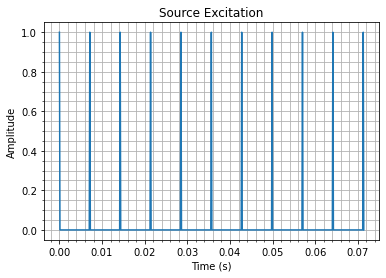


Filter response



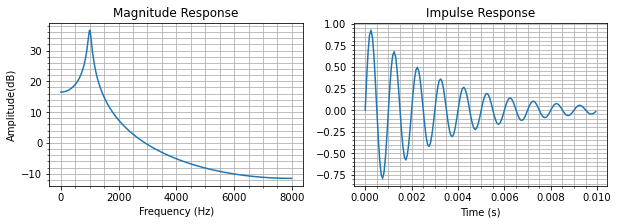

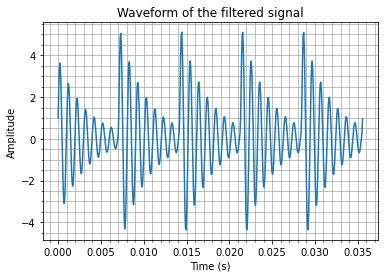

In [39]:
# Generate source signal
x=generate_source(f0,fs,duration)
ipd.display(ipd.Audio(data=x, rate=fs))

# Obtain filter coefficients
denom=generate_filter_single(F1, B1, fs)

# Filter the source
y=filter_lti(x,denom,f0,fs)
ipd.display(ipd.Audio(data=y, rate=fs))

<br>
The filter above only contains a single pole and offers limited control on the synthesized sound. The function below is used to generate a three-formant filter, as a cascade of three second-order sections.

In [40]:
def generate_filter_3form(F0, F1, F2, F3, B1, Fs):
    '''
    Arguments:
    F0 - source excitation frequency
    F1, F2, F3 - resonating frequencies
    B1 - resonating frequncy bandwidth
    Fs - sampling rate

    Returns:
    denoms - a tuple of three sets of denom coefficients
    '''
    Ts=1.0/Fs
    r1 = np.exp(-1*np.pi*B1*Ts)
    theta1 = 2*np.pi*F1*Ts
    theta2 = 2*np.pi*F2*Ts
    theta3 = 2*np.pi*F3*Ts
    denom1 = [1, -2*r1*np.cos(theta1), np.square(r1)]
    denom2 = [1, -2*r1*np.cos(theta2), np.square(r1)]
    denom3 = [1, -2*r1*np.cos(theta3), np.square(r1)]
    
    return (denom1, denom2, denom3)

To make it more realistic, set the three formant frequencies to correspond to those of some vowels in English

In [41]:
# parameters

F0 = 120
formant_freqs = {'a':[730,1090,2440], 'i':[270, 2290, 3010], 'u':[300, 870, 2240]}
B1 = 100
vowel = 'a'    # pick a vowel - 'a' or 'i' or 'u'
F1,F2,F3 = formant_freqs[vowel]

Synthesize the vowel-like sound by first generating a source, selecting a vowel & designing the corresponding filter, and then applying it. The 3-formant filter above returns three sets of denominator coefficients, each corresponding to a second order section with three coefficients. The overall filter is a cascade of these three sections and can be realised by applying each of these filters in series.

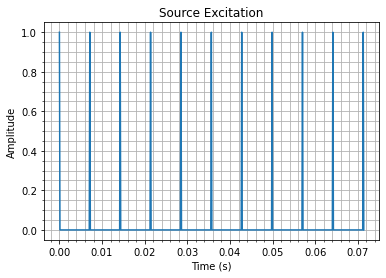

Output of section 1



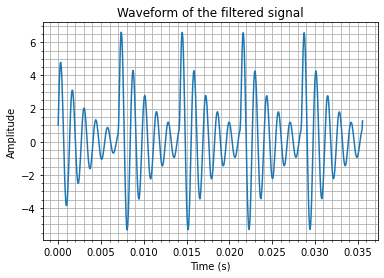

Output of section 2



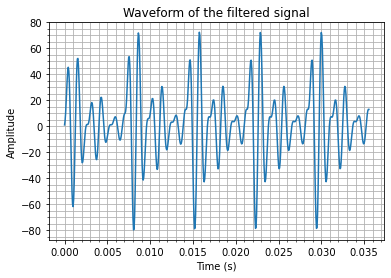

Output of section 3



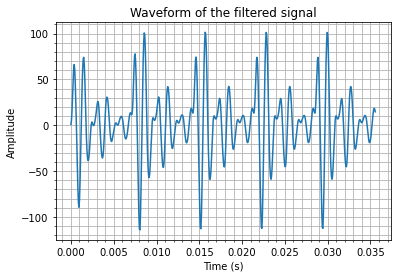

In [42]:
# Generate excitation signal
x = generate_source(f0,fs,duration)
ipd.display(ipd.Audio(data=x, rate=fs))

# Obtain the denominator coefficients of each of the second-order sections
denoms = generate_filter_3form(F0,F1,F2,F3,B1,fs)

# Apply filters iteratively and plot output of each second-order filter
y=x
i=1
for denom in denoms:
    print('Output of section %d\n'%i); i+=1
    y=filter_lti(y,denom,f0,fs)
    ipd.display(ipd.Audio(data=y, rate=fs))


<br><br>
In the single formant case, to obtain the filter magnitude and impulse response, we used the function 'freqz' from scipy. We can also find these responses by setting the source activation to be an impulse, as shown below.

Output of section 1



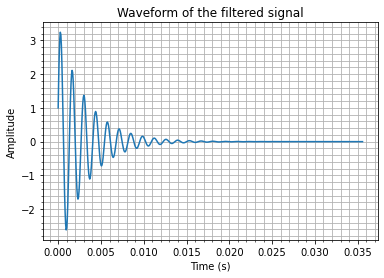

Output of section 2



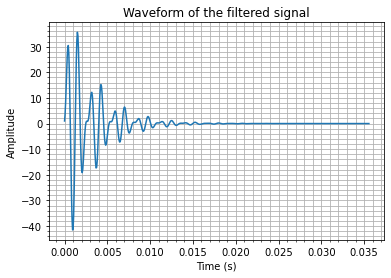

Output of section 3



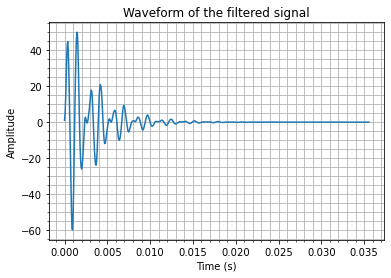

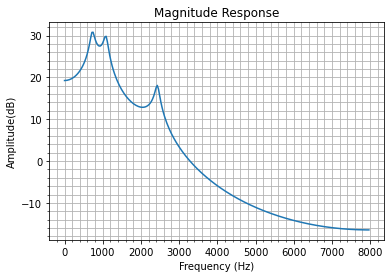

In [43]:
# Impulse source
fs = 16000
duration = 1
x=np.zeros(int(fs*duration))
x[0]=1

# Filter x using above generated filter
y=x
i=1
for denom in denoms:
    print('Output of section %d\n'%i); i+=1
    y=filter_lti(y,denom,f0,fs)
    ipd.display(ipd.Audio(data=y, rate=fs))

# Plot the magnitude response
y_spec = np.abs(np.fft.rfft(y,512))
f = np.arange(len(y_spec))*fs/(2*len(y_spec))

plt.figure()
plt.plot(f, 10*np.log10(y_spec))
plt.ylabel('Amplitude(dB)'); plt.xlabel('Frequency (Hz)')
plt.title('Magnitude Response')
plt.minorticks_on(); plt.grid(which='both')

plt.show()

<br><br>
## 3. A simple example of generating a melody using the synthesis blocks from above

In this task, we will generate a melody by synthesizing the corresponding the notes and setting the durations of each note appropriately. You can use the chart below as a reference for the absolute F0 values of musical notes.

| Note | Freq (Hz)   | Note | Freq (Hz)   | Note | Freq (Hz)   |
|------|-------------|------|-------------|------|-------------|
|   C1 |     131     |   F  |     175     |   A# |     233     |
|   C# |     139     |   F# |     185     |   B  |     247     |
|   D  |     147     |   G  |     196     |   C2 |     262     |
|   D# |     156     |   G# |     208     |
|   E  |     165     |   A  |     220     |

Following is the note sequence(score) for a popular melody. Each tuple specifies (Note, #beats). Take 1 beat = 400 ms.  

(C,1) (C, 1) (D,2) (C,2) (F,2) (E,4);

(C,1) (C,1) (D,2) (C,2) (G,2) (F,4);

(C,1) (C,1) (C2,2) (A,2) (F,2) (E,2) (D,2);

(A#,1) (A#,1) (A,2) (F,2) (G,2) (F,4);

<br>
Convert the above note-freq. chart and score to a python dictionary and list, respectively

In [44]:
note_freq = {'C':131, 'C#':139, 'D':147, 'D#':156, 
         'E':165, 'F':175, 'F#':185, 'G':196, 
         'G#':208, 'A':220, 'A#':233, 'B':247, 'C2':262}

melody = [('C',1), ('C', 1), ('D',2), ('C',2), ('F',2), ('E',4), 
          ('C',1), ('C',1), ('D',2), ('C',2), ('G',2), ('F',4), 
          ('C',1), ('C',1), ('C2',2), ('A',2), ('F',2), ('E',2), ('D',2),
          ('A#',1), ('A#',1), ('A',2), ('F',2), ('G',2), ('F',4)]


<br>
Then synthesize the melody using any of the three methods from above. Uncomment the method you wish to use. 

In [28]:
fs = 16000
beat_dur = 400e-3

synth_song = np.array([])
for note in melody:
    f0 = note_freq[note[0]]
    duration = note[1]*beat_dur
    
    '''
    # synthesize note using a complex tone
    x = generate_complex_tone(f0,fs,[1,1,1,1,1],[0,0,0,0,0],duration)
    '''
    
    ## OR
    
    '''
    # synthesize note using a single formant resonator
    x = generate_source(f0, fs, duration, plot=False)
    denom=generate_filter_single(500, 100, fs, plot=False)
    x=filter_lti(x, denom, f0, fs, plot=False)
    '''
    
    ## OR
    
    
    # synthesize note using 3 formant resonator
    x = generate_source(f0, fs, duration, plot=False)
    vowel = 'a'    # pick a vowel - 'a' or 'i' or 'u'
    F1,F2,F3 = formant_freqs[vowel]
    denoms = generate_filter_3form(F0,F1,F2,F3,B1,fs)
    for denom in denoms:
        x=filter_lti(x, denom, f0, fs, plot=False)
    
    
    # append to synth_song array:
    synth_song = np.append(synth_song, x)
    
ipd.display(ipd.Audio(data=synth_song, rate=fs))



NameError: name 'melody' is not defined

<br><b>Acknowledgement</b>: This notebook was created by Rohit M A and Kamini Sabu, graduate students at DAP Lab, Dept of EE, IIT Bombay.<br>
Please contact rohitma@iitb.ac.in in case of any queries.

# observation

on changing the function generate_complex_tone with n_comp by 5,7,9 observation has been made here by applying in the
 x = generate_complex_tone(f0,fs,[1,1,1,1,1],[0,0,0,0,0],duration) we get:
 
1. on taking 5 ones there is a sound disturbance in 4th second and pith is not continous as in 4th second pitch goes high
 
2. on taking 7 ones no sound disturbance and continous sound
  
3.  on taking 9 ones slight pitch of sound has increased
 